In [1]:
import numpy as np
import renom as rm
from sklearn.datasets import fetch_mldata
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import renom.utility.distributor.distributor as distr
import renom.cuda as cu
import matplotlib.pyplot as plt

In [2]:
# First, we gather the normal MNIST Data set and set up the data as per usual

mnist = fetch_mldata('MNIST original', data_home='../dataset')
X = mnist.data.astype(np.float32)
X /= np.amax(X)
X = X.reshape(-1, 1, 28, 28)
Y = mnist.target
Y = LabelBinarizer().fit_transform(Y).astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1)

In [3]:
# We construct the model in two variants, one that can uses layer normalization and one that does not
# The one utilizing layer normalization has more units to train, as gain and bias are trainable parameters

class MNist(rm.Model):
    def __init__(self, use_norm = False):
        super(MNist,self).__init__()
        self._norm = use_norm
        if use_norm:
            self.norm = rm.LayerNormalize()
        
        self.l1 = rm.Conv2d(channel=32,filter=5,padding=2)
        self.a1 = rm.Relu()
        self.l2 = rm.MaxPool2d(filter=2,stride=2)
        self.l3 = rm.Conv2d(channel=64,filter=5,padding=2)
        self.l4 = rm.MaxPool2d(filter=2,stride=2)
        self.l5 = rm.Dense(1024)
        self.l6 = rm.Dense(10)
        
    def forward(self, x):
        ret = self.l1(x)
        ret = self.l2(ret)
        ret = self.a1(ret)
        ret = self.l3(ret)
        ret = self.l4(ret)
        ret = self.a1(ret)
        ret = ret.reshape(ret.shape[0],-1)
        ret = self.l5(ret)
        if self._norm:
            ret = self.norm(ret)
        ret = self.a1(ret)
        ret = self.l6(ret)
        return ret

In [4]:
# Set up hyperparameters

cu.set_cuda_active(True)
epochs = 10
opt = rm.Sgd(0.01)
batch_size = 128
train_distributor = distr.NdarrayDistributor(X_train,y_train)
# Since we are training one relatively large datasets, we construct another distributor for the test data,
# in order to avoid using too much memory and doing the test in batches.
test_distributor = distr.NdarrayDistributor(X_test, y_test)
normed_model = MNist(use_norm = True)
regular_model = MNist(use_norm = False)
batches = X_train.shape[0]

In [5]:
# Here we perform the training. For each epoch we first train the normalized model once and then the regular model.
def train_model(args):
    distributor, model, train = args
    loss = 0
    for batch_x, batch_y in distributor.batch(batch_size):
        if train:
            with model.train():
                z = model(batch_x)
                l = rm.softmax_cross_entropy(z,batch_y)
            l.grad().update(opt)
        else:
            z = model(batch_x)
            l = rm.softmax_cross_entropy(z,batch_y)
        loss += l.as_ndarray()
    return loss/(len(distributor)//batch_size+1)
    

normed_loss = []
normed_test = []
regular_loss = []
regular_test = []

from concurrent.futures import ThreadPoolExecutor

for e in range(epochs):
    with ThreadPoolExecutor(max_workers=2) as executor:
        normed_process = executor.submit(train_model, (train_distributor, normed_model, True))
        regular_process = executor.submit(train_model, (train_distributor, regular_model, True))
        normed_loss.append(normed_process.result())
        regular_loss.append(regular_process.result())
    print('Finished epoch #{:d} with normalized loss: {} and regular loss: {}'.format(e+1,normed_loss[-1],regular_loss[-1]))
    
    normed_test.append(train_model((test_distributor, normed_model, False)))
    regular_test.append(train_model((test_distributor, regular_model, False)))
    print('Normalized test loss of {} and regular test loss of {}'.format(normed_test[-1], regular_test[-1]))

Finished epoch #1 with normalized loss: [ 0.69828564] and regular loss: [ 0.6326496]
Normalized test loss of [ 0.22982723] and regular test loss of [ 0.22041677]
Finished epoch #2 with normalized loss: [ 0.16709965] and regular loss: [ 0.17350271]
Normalized test loss of [ 0.14164113] and regular test loss of [ 0.20164409]
Finished epoch #3 with normalized loss: [ 0.10731229] and regular loss: [ 0.1190723]
Normalized test loss of [ 0.08869755] and regular test loss of [ 0.12238833]
Finished epoch #4 with normalized loss: [ 0.08226684] and regular loss: [ 0.09191553]
Normalized test loss of [ 0.0727101] and regular test loss of [ 0.08572799]
Finished epoch #5 with normalized loss: [ 0.06748869] and regular loss: [ 0.07756034]
Normalized test loss of [ 0.06798359] and regular test loss of [ 0.07334501]
Finished epoch #6 with normalized loss: [ 0.05807455] and regular loss: [ 0.06686685]
Normalized test loss of [ 0.05802559] and regular test loss of [ 0.06892944]
Finished epoch #7 with no

<IPython.core.display.Javascript object>


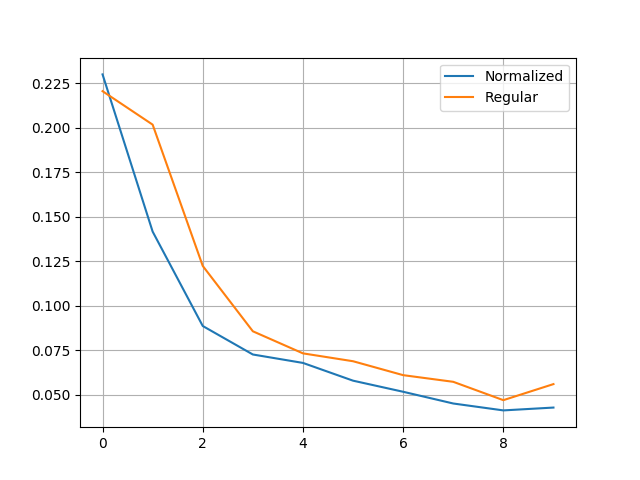

In [6]:
%matplotlib notebook

# Now we plot the data together to show the effect of normalization, nothing too fancy here.

plt.plot(range(len(normed_test)),normed_test, label="Normalized")
plt.plot(range(len(regular_test)),regular_test, label="Regular")
plt.legend()
plt.grid()
plt.show()

In [7]:
print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(normed_model(X_test).as_ndarray(), axis=1)))
print(classification_report(np.argmax(y_test, axis=1), np.argmax(normed_model(X_test).as_ndarray(), axis=1)))

[[651   0   0   0   0   0   1   0   2   1]
 [  0 777   0   1   0   0   0   1   0   0]
 [  0   1 667   3   0   0   0   5   1   1]
 [  1   1   1 700   0   1   0   4   0   0]
 [  0   0   0   0 688   0   1   4   0   3]
 [  1   0   0   2   0 652   0   0   0   0]
 [  2   1   0   0   0   4 659   0   0   0]
 [  0   2   0   2   1   0   0 748   0   0]
 [  1   2   0   0   2   7   2   2 665   4]
 [  3   1   0   2   5   0   0   9   0 705]]
             precision    recall  f1-score   support

          0       0.99      0.99      0.99       655
          1       0.99      1.00      0.99       779
          2       1.00      0.98      0.99       678
          3       0.99      0.99      0.99       708
          4       0.99      0.99      0.99       696
          5       0.98      1.00      0.99       655
          6       0.99      0.99      0.99       666
          7       0.97      0.99      0.98       753
          8       1.00      0.97      0.98       685
          9       0.99      0.97      

In [8]:
print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(regular_model(X_test).as_ndarray(), axis=1)))
print(classification_report(np.argmax(y_test, axis=1), np.argmax(regular_model(X_test).as_ndarray(), axis=1)))

[[647   2   1   0   0   0   1   0   1   3]
 [  0 778   0   0   0   0   0   0   0   1]
 [  0   0 671   1   0   0   0   0   2   4]
 [  1   1   1 698   0   0   1   0   2   4]
 [  0   0   0   0 678   0   1   0   0  17]
 [  1   0   0   3   0 643   1   0   3   4]
 [  2   1   0   0   0   3 658   0   2   0]
 [  1   4   5   2   1   0   0 716   3  21]
 [  0   4   0   0   3   1   2   2 663  10]
 [  1   1   0   2   1   0   0   0   0 720]]
             precision    recall  f1-score   support

          0       0.99      0.99      0.99       655
          1       0.98      1.00      0.99       779
          2       0.99      0.99      0.99       678
          3       0.99      0.99      0.99       708
          4       0.99      0.97      0.98       696
          5       0.99      0.98      0.99       655
          6       0.99      0.99      0.99       666
          7       1.00      0.95      0.97       753
          8       0.98      0.97      0.97       685
          9       0.92      0.99      